# 8/15/22 (By Lauren Urban)

In [1]:
# Load EDA Pkgs
import pandas as pd
import numpy as np
from numpy.linalg import solve, norm
from numpy.random import rand

# Load Data Viz Pkgs
from IPython.display import display, YouTubeVideo
import plotly.io as pio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
import plotly.tools as tls
from tqdm.notebook import tqdm
import seaborn as sns

# Sci-kit-learn packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Transformers
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import StandardScaler, scale
from scipy.sparse import csr_matrix, lil_matrix # sparse matrix format
from scipy.sparse.linalg import spsolve
from sklearn.cross_decomposition import PLSRegression


# Load Classifiers
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold  
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             plot_confusion_matrix, mean_squared_error)
import warnings
warnings.filterwarnings('ignore')
%matplotlib notebook

# Import user-defined functions
import * from ML_drug_synergy_classifier.ml_scripts.outlier_detection

In [5]:
# Define Variables
fig = go.Figure() # or any Plotly Express function e.g. px.bar(...)

SMALL_SIZE = 12
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

In [216]:
# Import data
df = pd.read_csv('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/data/tidy data/final_combined_tidydf_Brochado2018_Molecular-descriptors_v4.csv', index_col = None)
print(df.shape)
print(df.dtypes)

(2368, 40)
Drug1                                      object
SMR                                       float64
XLogP                                     float64
TPSA                                      float64
NumLipinskiHBA                              int64
NumLipinskiHBD                              int64
NumRotatableBonds                           int64
NumHeavyAtoms                               int64
NumRings                                    int64
HallKierAlpha                             float64
Atomic_Polarizabilities                   float64
Element_Count                               int64
Eccentric_Connectivity_Index                int64
VABC_Volume_Descriptor                    float64
Vertex_adjacency_information_magnitude    float64
Zagreb_Index                                int64
Me                                        float64
TIE                                       float64
Psi_i_A                                   float64
Psi_e_A                                

In [217]:
df1 = df.drop(columns = ['Synergyscore_ECBW', 'Synergyscore_ECiAi1', 
                          'Synergyscore_STLT2', 'Synergyscore_ST14028'])

df1.drop_duplicates(inplace = True)

In [454]:
df_blactam = df1.loc[(df1.Drug2_Class=='beta-lactam')]
df_blactam= df_blactam.reset_index(drop=True)
print (df_blactam.shape)
print (df_blactam.dtypes)

(179, 33)
Drug1                                      object
XLogP                                     float64
SMR                                       float64
TPSA                                      float64
NumLipinskiHBA                              int64
NumLipinskiHBD                              int64
NumRotatableBonds                           int64
NumHeavyAtoms                               int64
NumRings                                    int64
HallKierAlpha                             float64
Atomic_Polarizabilities                   float64
Element_Count                               int64
Eccentric_Connectivity_Index                int64
VABC_Volume_Descriptor                    float64
Vertex_adjacency_information_magnitude    float64
Zagreb_Index                                int64
Drug1_Class                                object
Drug2_Class                                object
Drug1_Target                               object
Drug2_Target                            

In [859]:
# Phi Coefficient is the same as Pearson for two binary variables
(df1["Outcome_PA01"]
     .corr(df1["Outcome_PA14"], method="pearson")
)
# 0.9205292564902204  (PAO1 and PA14)
# -0.28713901978847256  (ECBW and PA14)
# -0.2592910360227505   (ECBW and PA01)
# -0.23283164727022104  (ST and PA01)
# -0.20083978043600575  (ST and PA41)
# -0.24718028226235875  (ST and ECBW)

0.9205292564902204

In [5]:
convert_dict = {'NumLipinskiHBA': float,
                'NumLipinskiHBD': float,
                'NumRotatableBonds': float,
                'NumHeavyAtoms': float,
                'NumRings': float,
                'Element_Count': float,
                'Eccentric_Connectivity_Index': float,
                'Zagreb_Index': float,
                'Outcome_PA01': 'int64',
                'Outcome_PA14': 'int64',
                'Outcome_ECBW': 'int64',
                'Outcome_ECiAi1': 'int64',
                'Outcome_STLT2': 'int64',
                'Outcome_ST14028': 'int64',
                }

df1 = df1.astype(convert_dict)
print(df1.dtypes)

Drug1                                      object
SMR                                       float64
XLogP                                     float64
TPSA                                      float64
NumLipinskiHBA                            float64
NumLipinskiHBD                            float64
NumRotatableBonds                         float64
NumHeavyAtoms                             float64
NumRings                                  float64
HallKierAlpha                             float64
Atomic_Polarizabilities                   float64
Element_Count                             float64
Eccentric_Connectivity_Index              float64
VABC_Volume_Descriptor                    float64
Vertex_adjacency_information_magnitude    float64
Zagreb_Index                              float64
Me                                        float64
TIE                                       float64
Psi_i_A                                   float64
Psi_e_A                                   float64


### Outlier Detection

In [195]:
OutLiersBox(df1, 'TPSA')
#plt.savefig('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/results/scikit/multi-label classifier/220815/all-Drugs2_balanced_TPSA_w_outliers.pdf', dpi=300)
plt.clf()

<Figure size 432x288 with 0 Axes>

One-Class SVM {-1: 234, 1: 751}
Robust covariance {-1: 99, 1: 886}
Isolation Forest {-1: 99, 1: 886}
Local Outlier Factor {-1: 92, 1: 893}


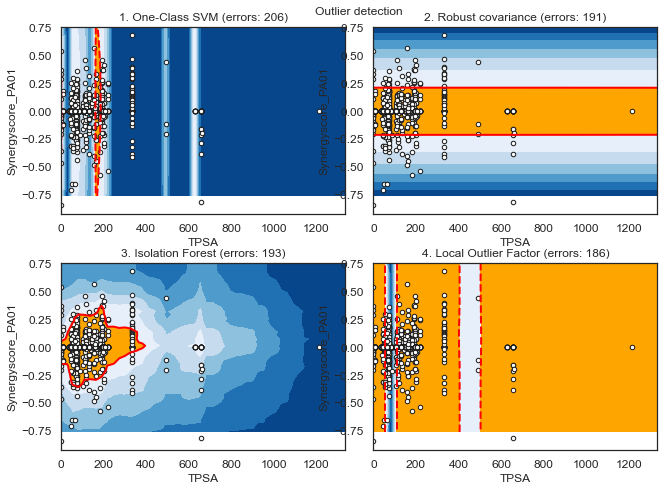

In [210]:
tt = OutLierDetection(df1,'TPSA','Synergyscore_PA01', 0.1)

Number of outliers (inc duplicates): 8 and outliers: [-9.08 -9.08 -9.08 -9.08 -9.08 -9.08 -9.08 -9.08]
New dataset with removed outliers has 977 samples with 36 features each.


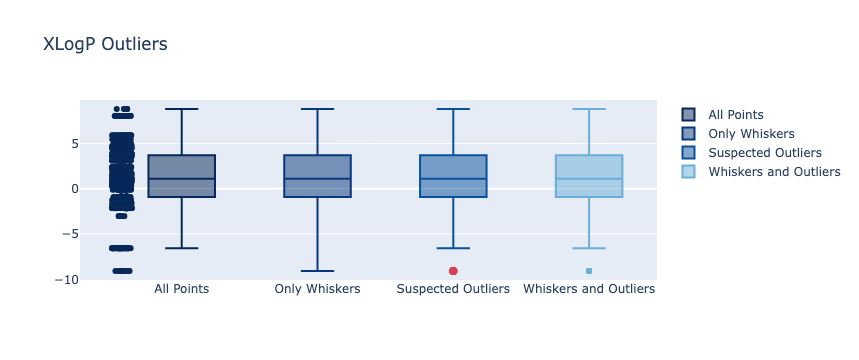

In [223]:
py.init_notebook_mode(connected=True)

df_clean = TurkyOutliers(df1, "XLogP",True)
OutLiersBox(df_clean, "XLogP")

PA01 Value counts 2    650
0    171
1    156
Name: Outcome_PA01, dtype: int64
PA14 Value counts 2    655
0    191
1    131
Name: Outcome_PA14, dtype: int64


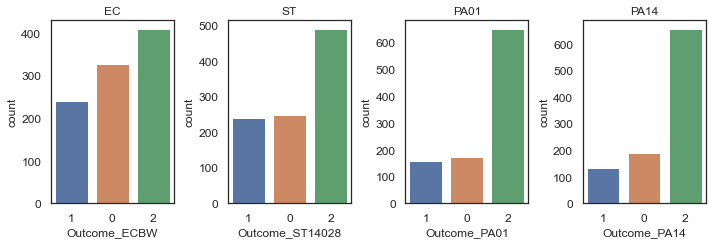

In [225]:
# generate countplots
order_list = [1,0,2]

#print ('EC Value counts', df_clean.Outcome_ECBW.value_counts())
#print ('ST Value counts', df_clean.Outcome_ST14028.value_counts())
print ('PA01 Value counts', df_clean.Outcome_PA01.value_counts())
print ('PA14 Value counts', df_clean.Outcome_PA14.value_counts())

%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(10, 3.5))

sns.countplot(x = 'Outcome_ECBW', data = df_clean, ax=ax[0], order = order_list).set(title='EC')
sns.countplot(x = 'Outcome_ST14028', data = df_clean, ax=ax[1], order = order_list).set(title='ST')
sns.countplot(x = 'Outcome_PA01', data = df_clean, ax=ax[2], order = order_list).set(title='PA01')
sns.countplot(x = 'Outcome_PA14', data = df_clean, ax=ax[3], order = order_list).set(title='PA14')
fig.tight_layout()

plt.savefig('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/results/scikit/EDA/Outcomes_molecular_descriptor_v4_Drug2_Bugs4_no_outliers.pdf', dpi=300)

EC Value counts 2    200
0     62
1     57
Name: Outcome_ECBW, dtype: int64
ST Value counts 2    228
1     50
0     41
Name: Outcome_ST14028, dtype: int64
PA01 Value counts 0    169
1    150
Name: Outcome_PA01, dtype: int64
PA14 Value counts 0    190
1    129
Name: Outcome_PA14, dtype: int64


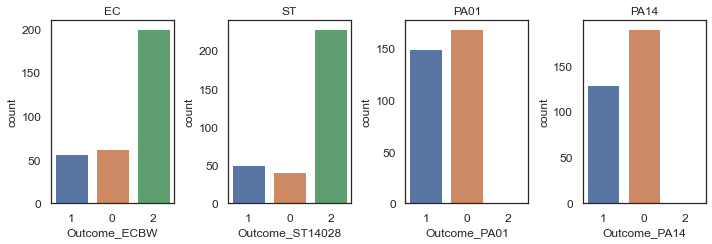

In [226]:
PA_df_clean3 = df_clean.drop(df_clean[(df_clean.Outcome_PA01==2) | (df_clean.Outcome_PA14==2)].index)
PA_df_clean3
order_list = [1,0,2]
print ('EC Value counts', PA_df_clean3.Outcome_ECBW.value_counts())
print ('ST Value counts', PA_df_clean3.Outcome_ST14028.value_counts())
print ('PA01 Value counts', PA_df_clean3.Outcome_PA01.value_counts())
print ('PA14 Value counts', PA_df_clean3.Outcome_PA14.value_counts())

%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(10, 3.5))
sns.countplot(x = 'Outcome_ECBW', data = PA_df_clean3, ax=ax[0], order = order_list).set(title='EC')
sns.countplot(x = 'Outcome_ST14028', data = PA_df_clean3, ax=ax[1], order = order_list).set(title='ST')
sns.countplot(x = 'Outcome_PA01', data = PA_df_clean3, ax=ax[2], order = order_list).set(title='PA01')
sns.countplot(x = 'Outcome_PA14', data = PA_df_clean3, ax=ax[3], order = order_list).set(title='PA14')
fig.tight_layout()

In [227]:
# convert [2] which is not sign outcomes to [0] antagonism
df_clean['Outcome_ECBW'] = df_clean['Outcome_ECBW'].replace([2],[0])
df_clean['Outcome_PA01'] = df_clean['Outcome_PA01'].replace([2],[0])
df_clean['Outcome_PA14'] = df_clean['Outcome_PA14'].replace([2],[0])
df_clean['Outcome_ST14028'] = df_clean['Outcome_ST14028'].replace([2],[0])

EC Value counts 0    736
1    241
Name: Outcome_ECBW, dtype: int64
ST Value counts 0    738
1    239
Name: Outcome_ST14028, dtype: int64
PA01 Value counts 0    821
1    156
Name: Outcome_PA01, dtype: int64
PA14 Value counts 0    846
1    131
Name: Outcome_PA14, dtype: int64


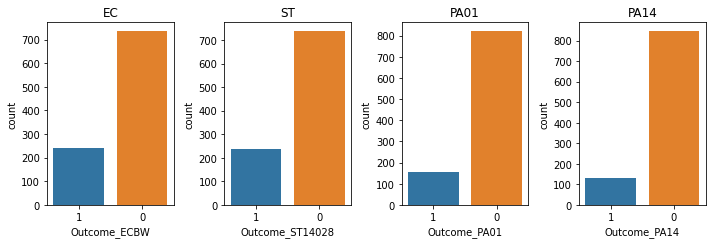

In [15]:
# generate countplots
order_list = [1,0]

print ('EC Value counts', df_clean.Outcome_ECBW.value_counts())
print ('ST Value counts', df_clean.Outcome_ST14028.value_counts())
print ('PA01 Value counts', df_clean.Outcome_PA01.value_counts())
print ('PA14 Value counts', df_clean.Outcome_PA14.value_counts())

%matplotlib inline
fig, ax = plt.subplots(1, 4, figsize=(10, 3.5))

sns.countplot(x = 'Outcome_ECBW', data = df_clean, ax=ax[0], order = order_list).set(title='EC')
sns.countplot(x = 'Outcome_ST14028', data = df_clean, ax=ax[1], order = order_list).set(title='ST')
sns.countplot(x = 'Outcome_PA01', data = df_clean, ax=ax[2], order = order_list).set(title='PA01')
sns.countplot(x = 'Outcome_PA14', data = df_clean, ax=ax[3], order = order_list).set(title='PA14')
fig.tight_layout()

#plt.savefig('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/results/scikit/EDA/Outcomes_Drug2_Class_Beta-lactam_3bugs_binary.pdf', dpi=300)

In [228]:
#Since we have an unbalanced dataset, we need to try to up-sampling the minority class.
#https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

# Separate majority and minority classes
PA_minority = df_clean[df_clean.Outcome_PA01==1]
PA14_minority = df_clean[df_clean.Outcome_PA14==1]
ST_minority = df_clean[df_clean.Outcome_ST14028==1]
EC_minority = df_clean[df_clean.Outcome_ECBW==1]

synergy_df = pd.concat([PA_minority, PA14_minority,ST_minority,EC_minority])

# Display new class counts
#print("PA value count", synergy_df['Outcome_PA01'].value_counts())
#print("PA value count", synergy_df['Outcome_PA14'].value_counts())
#print("ST value count", synergy_df['Outcome_ST14028'].value_counts())
#print("EC value count", synergy_df['Outcome_ECBW'].value_counts())


# Upsample majority class
majority = df_clean[(df_clean.Outcome_PA01==0) & (df_clean.Outcome_PA14==0) & (df_clean.Outcome_ECBW==0) &(df_clean.Outcome_ST14028==0) ]

minority = df_clean[(df_clean.Outcome_PA01==1) & (df_clean.Outcome_PA14==1) & (df_clean.Outcome_ST14028==0)]


minority_upsampled = resample(minority, 
                             replace=True,     # sample with replacement
                             n_samples=100,    # to match majority class
                             random_state=123) # reproducible results
minority_upsampled.shape
# add the majority 
df_balanced = pd.concat([synergy_df, minority_upsampled])

# Display new class counts
print("PA value count", df_balanced['Outcome_PA01'].value_counts())
print("PA value count", df_balanced['Outcome_PA14'].value_counts())
print("ST value count", df_balanced['Outcome_ST14028'].value_counts())
print("EC value count", df_balanced['Outcome_ECBW'].value_counts())

#df_balanced.to_csv('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/data/tidy data/balanced_final_combined_tidydf_Brochado2018_Molecular-descriptors_v4.csv', sep=",", index = False)

PA value count 0    439
1    428
Name: Outcome_PA01, dtype: int64
PA value count 0    455
1    412
Name: Outcome_PA14, dtype: int64
ST value count 0    452
1    415
Name: Outcome_ST14028, dtype: int64
EC value count 1    441
0    426
Name: Outcome_ECBW, dtype: int64


EC Value counts 1    441
0    426
Name: Outcome_ECBW, dtype: int64
ST Value counts 0    452
1    415
Name: Outcome_ST14028, dtype: int64
PA01 Value counts 0    439
1    428
Name: Outcome_PA01, dtype: int64
PA14 Value counts 0    455
1    412
Name: Outcome_PA14, dtype: int64


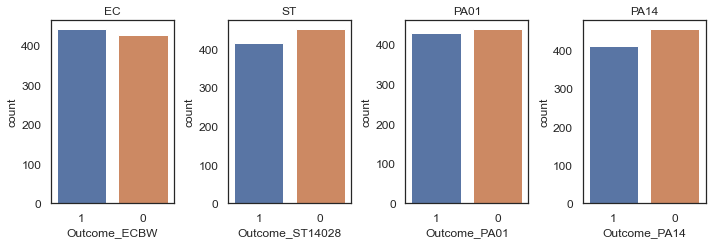

In [229]:
# balance the data across the bacteria (PA have lowest counts so find the rows that keep all synergy outcomes for PA strains and ST)
#print(df_clean2.shape)

# drop the rows in which the outcome is 0 across all three conditions
#df_clean3 = df_clean2.drop(df_clean2[(df_clean2.Outcome_PA01==0) & (df_clean2.Outcome_PA14==1)].index)
#print(df_clean3.shape)

%matplotlib inline
order_list = [1,0]
fig, ax = plt.subplots(1, 4, figsize=(10, 3.5))
sns.countplot(x = 'Outcome_ECBW', data = df_balanced, ax=ax[0], order = order_list).set(title='EC')
sns.countplot(x = 'Outcome_ST14028', data = df_balanced, ax=ax[1], order = order_list).set(title='ST')
sns.countplot(x = 'Outcome_PA01', data = df_balanced, ax=ax[2], order = order_list).set(title='PA01')
sns.countplot(x = 'Outcome_PA14', data = df_balanced, ax=ax[3], order = order_list).set(title='PA14')
fig.tight_layout()
plt.savefig('/Users/lauren/Vegify Dropbox/Lauren Urban/Synergy AMPs project/results/scikit/EDA/Outcomes_molecular_descriptor_v4_Drug2_Bugs4_no_outliers_balanced.pdf', dpi=300)
print ('EC Value counts', df_balanced.Outcome_ECBW.value_counts())
print ('ST Value counts', df_balanced.Outcome_ST14028.value_counts())
print ('PA01 Value counts', df_balanced.Outcome_PA01.value_counts())
print ('PA14 Value counts', df_balanced.Outcome_PA14.value_counts())

In [230]:
# Using sklearn to shuffle rows
from sklearn.utils import shuffle
# shuffle the rows
df_balanced = shuffle(df_balanced)
ID_list = df_balanced['Drug1']
#df1 = df1.drop(columns = 'index')
df_balanced = df_balanced.reset_index(drop=True)
print(df_balanced)

            Drug1       SMR  XLogP    TPSA  NumLipinskiHBA  NumLipinskiHBD  \
0      Cefsulodin  122.9422  0.738  190.88              12               4   
1    Benzalkonium  103.5824  8.053    0.00               1               0   
2      Novobiocin  158.9210  4.492  200.01              13               6   
3      Rifampicin  220.4792  3.996  220.15              16               6   
4        Procaine   68.9249  1.840   55.56               4               2   
..            ...       ...    ...     ...             ...             ...   
862  Piperacillin  127.3402  0.328  156.43              12               3   
863      Procaine   68.9249  1.840   55.56               4               2   
864   Amoxicillin   90.6937 -2.138  132.96               8               5   
865    Bacitracin  444.8963  0.326  658.15              40              24   
866          EGCG  108.9209  3.581  197.37              11               8   

     NumRotatableBonds  NumHeavyAtoms  NumRings  HallKierAlpha 

In [231]:

df_balanced2 = df_balanced.drop(columns =['Drug1_Class', 'Drug2_Class','Drug1_Target', 'Drug2_Target', 'Drug1', 'Synergyscore_PA01', 'Synergyscore_PA14'])
df_balanced2.dtypes

SMR                                       float64
XLogP                                     float64
TPSA                                      float64
NumLipinskiHBA                              int64
NumLipinskiHBD                              int64
NumRotatableBonds                           int64
NumHeavyAtoms                               int64
NumRings                                    int64
HallKierAlpha                             float64
Atomic_Polarizabilities                   float64
Element_Count                               int64
Eccentric_Connectivity_Index                int64
VABC_Volume_Descriptor                    float64
Vertex_adjacency_information_magnitude    float64
Zagreb_Index                                int64
Me                                        float64
TIE                                       float64
Psi_i_A                                   float64
Psi_e_A                                   float64
Hy                                        float64


In [304]:
# Build A Pipeline for our Model to preprocessing descriptors (X) variables
# Load Preprocessing packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline  #if you need to scale or center data before training/testing 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
# Transformers
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline  # to create a pipeline 
# split into training and testing dfs
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import set_config
# Use LabelBinarizer to transform the y variable for Multilabel classification 
from sklearn import preprocessing
le = preprocessing.LabelBinarizer()
mle = preprocessing.MultiLabelBinarizer()
onehot_encoder = preprocessing.OneHotEncoder()
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
enc = preprocessing.OrdinalEncoder()

set_config(display='diagram')

# Preprocessing descriptors (X) variables
numeric_features = ['XLogP', 'SMR', 'TPSA','NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha', 
                    'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 
                    'Vertex_adjacency_information_magnitude',  'Zagreb_Index', 'Me', 'TIE', 'Psi_i_A', 'Psi_e_A', 'Hy', 'Xt', 'MDDD']

category_features = ['Drug2']

# pipeline for categorical and numeric columns
num_preprocessor = StandardScaler()  # Use StandardScaler to normalize numeric. NaNs are treated as missing values: disregarded in fit, and maintained in transform.
cat_preprocessor = OneHotEncoder(handle_unknown='ignore', sparse = False) # creating instance of labelencoder

# combine numeric and column transformations
preprocessor = ColumnTransformer([("num", num_preprocessor, numeric_features)], remainder='passthrough')

# combine numeric and column transformations
full_preprocessor = ColumnTransformer(transformers=[
    ("num", num_preprocessor, numeric_features), 
    ("cat", cat_preprocessor, category_features)], remainder='drop')
# After applying the transformation you will get a Numpy array and the total columns transformed increases because the Drug2 column is spread out into different columns.
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA',
                                  'NumLipinskiHBD', 'NumRotatableBonds',
                                  'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
                                  'Atomic_Polarizabilities', 'Element_Count',
                                  'Eccentric_Connectivity_Index',
                                  'VABC_Volume_Descriptor',
                                  'Vertex_adjacency_information_magnitude',
                                  'Zagreb_Index', 'Me', 'TIE', 'Psi_i_A',
                                  'Psi_e_A', 'Hy', 'Xt', 'MDDD'])])

In [326]:
#split the data into variables X and a target variable y.
# features
X = df_balanced2[['Drug2', 'XLogP','TPSA', 'SMR', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha', 
                    'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 
                    'Vertex_adjacency_information_magnitude',  'Zagreb_Index', 'Me', 'TIE', 'Psi_i_A', 'Psi_e_A', 'Hy', 'Xt', 'MDDD']]
    
#X = X.set_index('Drug1') #convert column cids to index 
print(X.shape)

numeric_colms= df_balanced2[['XLogP', 'SMR','TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha', 'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude',  'Zagreb_Index']]
#numeric_colms = numeric_colms.set_index('Drug1') #convert column cids to index 


# Features and labels
feature_names = (X.columns) #Get a feature list to use for importances later on
# 'Outcome_ECBW','Outcome_ST14028',
y = df_balanced2[['Outcome_PA01', 'Outcome_PA14', 'Outcome_ECBW', 'Outcome_ST14028']]
#y_groups = df_clean3[['Outcome_ECBW', 'Outcome_ST14028', 'Outcome_PA01', 'Outcome_PA14']]
y01 = df_balanced2[['Outcome_PA01']]

print(y.dtypes)
print(type_of_target(y))

(867, 23)
Outcome_PA01       int64
Outcome_PA14       int64
Outcome_ECBW       int64
Outcome_ST14028    int64
dtype: object
multilabel-indicator


In [609]:
## https://www.ritchieng.com/machine-learning-project-student-intervention/
def preprocess_features(X):
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is non-numeric, replace all yes/no values with 1/0
        #if col_data.dtype == object:
          #  col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)

        # Collect the revised columns
        output = output.join(col_data)

    return output

X_all = preprocess_features(X)
print(X_all)

     Drug2_A22  Drug2_Acetylsalisylic acid  Drug2_Amikacin  \
0            0                           0               0   
1            0                           0               0   
2            0                           0               0   
3            0                           0               0   
4            0                           0               0   
..         ...                         ...             ...   
862          0                           0               0   
863          0                           0               0   
864          0                           0               1   
865          0                           0               0   
866          0                           1               0   

     Drug2_Azithromycin  Drug2_Aztreonam  Drug2_Bacitracin  \
0                     0                1                 0   
1                     0                0                 0   
2                     0                0                 0   
3      

In [303]:
print(X_all.dtypes)

Drug2_A22                       uint8
Drug2_Acetylsalisylic acid      uint8
Drug2_Amikacin                  uint8
Drug2_Azithromycin              uint8
Drug2_Aztreonam                 uint8
                               ...   
Psi_i_A                       float64
Psi_e_A                       float64
Hy                            float64
Xt                            float64
MDDD                          float64
Length: 94, dtype: object


In [557]:
# https://www.ritchieng.com/machinelearning-one-hot-encoding/
# limit to categorical data using df.select_dtypes()
from sklearn.preprocessing import OneHotEncoder
X1 = X.select_dtypes(include=[object])
print(X1.head(30))

# 1. INSTANTIATE
# encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()

# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_2 = X1.apply(le.fit_transform)

print(X_2.head(30))
# TODO: create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(X_2)

# 3. Transform
onehotlabels = enc.transform(X_2).toarray()
#onehotlabels.shape
# as you can see, you've the same number of rows 49
# but now you've so many more columns due to how we changed all the categorical data into numerical data

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# combine encoded categorical column with feature column
numeric_colms
#X = pd.concat([numeric_colms, pd.DataFrame(onehotlabels)], axis=1)

                   Drug2
0              Verapamil
1         Nitrofurantoin
2            Mitomycin C
3                    A22
4              Pyocyanin
5            Mitomycin C
6               Procaine
7           Trimethoprim
8               Amikacin
9              Metformin
10          Piperacillin
11            Bacitracin
12  Acetylsalisylic acid
13              Caffeine
14             Aztreonam
15             Bleomycin
16            Ciclopirox
17          Moxifloxacin
18        Nitrofurantoin
19        Clarithromycin
20        Clarithromycin
21              Colistin
22  Acetylsalisylic acid
23  Acetylsalisylic acid
24          Piperacillin
25           Flucytosine
26            Phleomycin
27             Pyocyanin
28          Levofloxacin
29              Colistin
    Drug2
0      62
1      42
2      40
3       0
4      53
5      40
6      50
7      60
8       2
9      37
10     49
11      5
12      1
13     11
14      4
15      8
16     18
17     41
18     42
19     19
20     19
21   

In [610]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y,
    test_size=0.33,
    shuffle=True,
    stratify=y,
    random_state=1
)

# Use this to preprocess without getting leaking to testing data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)  
print(X_test)

#  MUST convert target (y_train, y_test) and features (X_train, X_test) into sparse matrix arrays *****
from sklearn import preprocessing
from sklearn import utils
from sklearn.utils.multiclass import type_of_target
y_train  = np.array(y_train,  dtype=int)  # convert into an array
y_test  = np.array(y_test,  dtype=int)  # convert into an array
print(y_test.dtype)

[[-0.9558105  -0.31137232 -0.15526631 ...  0.          0.
   0.        ]
 [ 2.02575289 -0.170844   -1.03576072 ...  0.          0.
   0.        ]
 [ 0.15536385  0.78281477  0.1755151  ...  0.          0.
   0.        ]
 ...
 [ 0.36806099 -0.71433349 -0.55915736 ...  0.          0.
   0.        ]
 [-2.25013259  0.13273759  1.16242906 ...  0.          0.
   0.        ]
 [ 0.36806099 -0.71433349 -0.55915736 ...  0.          0.
   0.        ]]
int64


# GridSearch to avoid overfitting ===========

In [575]:
# GridSearch to avoid overfitting for AdaBoost Classifier with LabelPowerset ===========
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# LabelPowerset, MultiOutputClassifier, ClassifierChain

parameters = [
    {'classifier': [ExtraTreesClassifier()],
     "classifier__max_depth": [3,5,10,15,20,None],
              "classifier__max_features": [1, 3, 7, None],
              "classifier__min_samples_split": [2, 3, 7, 10],
               "classifier__min_samples_leaf": [1,2, 3, 5,7],
              "classifier__n_estimators" :[10, 20, 50, 100, 300],
              "classifier__criterion": ['gini', 'entropy']},]

print(f"Running Model: DecisionTreeClassifier Classifier")
clf = GridSearchCV(LabelPowerset(), parameters, scoring='accuracy', cv = 10)
grid_cv = clf.fit(X_train, y_train)
print("Param for GS", grid_cv.best_params_)
print("CV score for GS", grid_cv.best_score_) 
    
print("Train AUC ROC Score for GS: ", roc_auc_score(y_train, grid_cv.predict(X_train).toarray())) # Use X.toarray() to convert to a dense numpy array.
print("Test AUC ROC Score for GS: ", roc_auc_score(y_test, grid_cv.predict(X_test).toarray())) # Use X.toarray() to convert to a dense numpy array.
    #AdaC_best = gsExtC.best_estimator_
    #print(gsExtC.best_score_)
    #print(gsExtC.best_params_)
    #ExtC_best = grid_cv.best_estimator_.get_params()
    #print('Best score: %0.3f' % ExtC_best.best_score_)
    #print('Best parameters set:')
    #predictions = ExtC_best.predict(X_test)
    #print(classification_report(y_test, predictions))

Running Model: DecisionTreeClassifier Classifier
Param for GS {'classifier': ExtraTreesClassifier(max_depth=15, max_features=None, min_samples_leaf=2,
                     min_samples_split=7, n_estimators=10), 'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 7, 'classifier__n_estimators': 10}
CV score for GS 0.6136363636363636
Train AUC ROC Score for GS:  0.8122133505914275
Test AUC ROC Score for GS:  0.6815317035905271


In [252]:
# Calculating Gini Impurity of a Pandas DataFrame Column
def gini_impurity(column):
    impurity = 1
    counters = Counter(column)
    for value in column.unique():
        impurity -= (counters[value] / len(column)) ** 2

    return impurity

In [ ]:
%%time
# Calculate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


cm = metrics.confusion_matrix(y_test.round(), preds.round())
ax = sns.heatmap(cm, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'}, fmt='g')
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])
plt.title('Seasonal Vaccine Confusion Matrix', pad=10.0)
ax.set(ylabel="True Label", xlabel="Predicted Label")
plt.show()

=============================================================Attempts with cross_validate

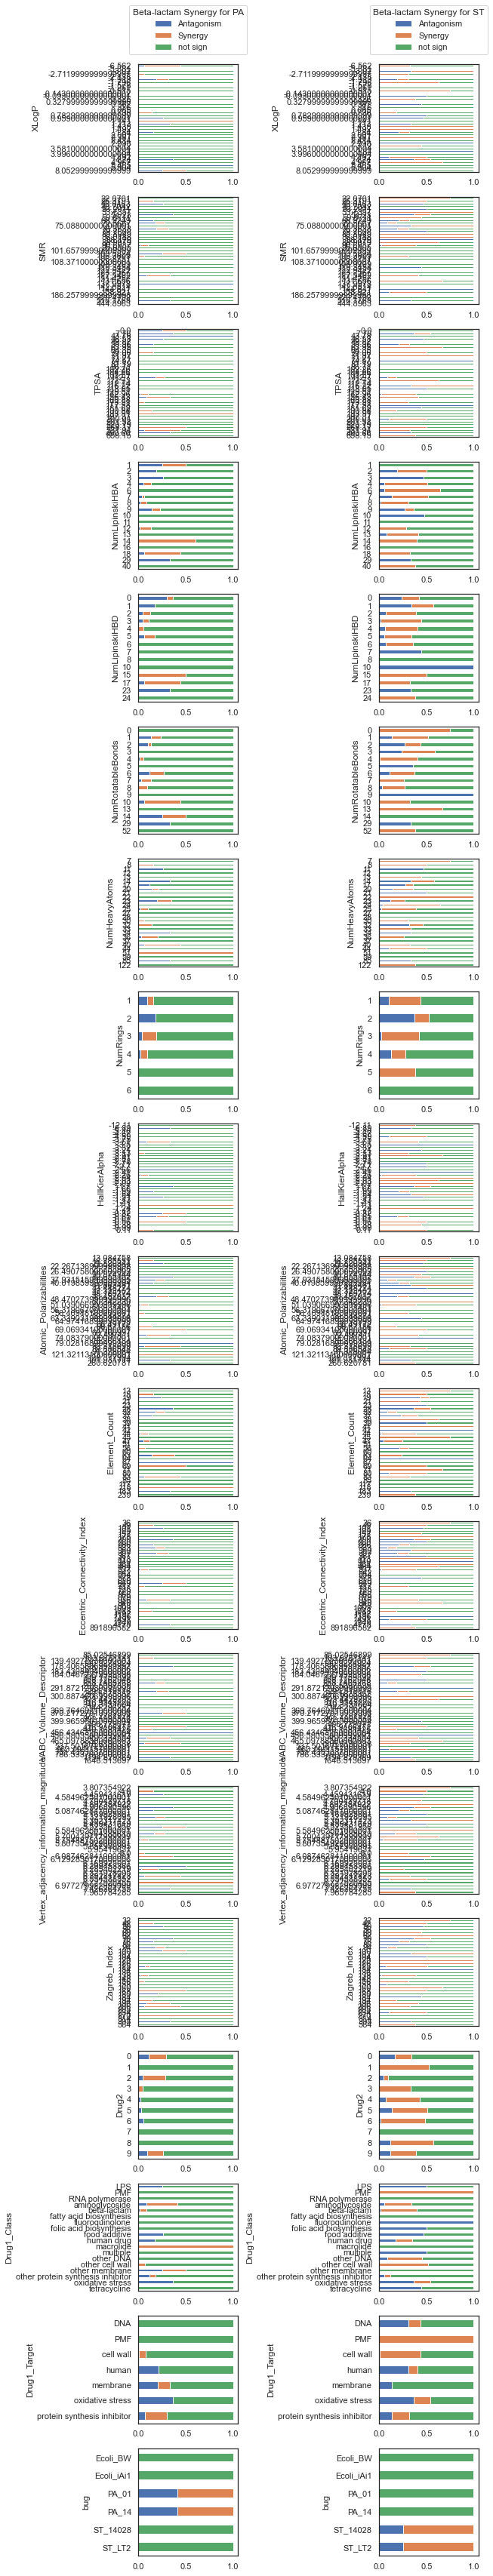

In [357]:
# Features and labels
cols_to_plot = ['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index', 'Drug2', 'Drug1_Class', 'Drug1_Target', 'bug'] 


fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    synergy_rate(
        cols_to_plot, 'PA', df1_wide, ax=ax[idx, 0]
    )
    synergy_rate(
        cols_to_plot, 'ST', df1_wide, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Beta-lactam Synergy for PA'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='Beta-lactam Synergy for ST'
)
fig.tight_layout()

In [ ]:
# Compute pairwise covariance of columns, excluding NA/null values.
PA_df4_cov =PA_df4.loc[:, 'XLogP':'Zagreb Index']
PA_df4_cov.cov()

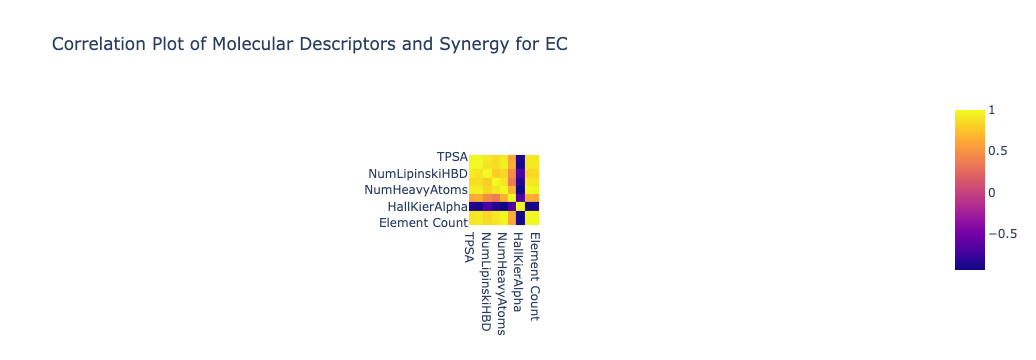

In [112]:
px.imshow(PA_df4.corr(),title="Correlation Plot of Molecular Descriptors and Synergy for PA")
px.imshow(ST_df4.corr(),title="Correlation Plot of Molecular Descriptors and Synergy for ST")
px.imshow(EC_df4.corr(),title="Correlation Plot of Molecular Descriptors and Synergy for EC")

Classification Metrics
> Accuracy.
> Logarithmic Loss.
> ROC, AUC.
> Confusion Matrix. (need to convert probability outputs to class output by creating a threshold probability). 
> Classification Report.
Regression Metrics
> Mean Absolute Error.
> Mean Squared Error.
> Root Mean Squared Error.
> Root Mean Squared Logarithmic Error.
> R Square.
> Adjusted R Square.

In classification problems , we use two types of algorithms (dependent on the kind of output it creates):

Class output : Algorithms like SVM and KNN create a class output. For instance, in a binary classification problem, the outputs will be either 0 or 1. SKLearn's/Other algorithms can convert these class outputs to probability.

Probability output : Algorithms like Logistic Regression, Random Forest, Gradient Boosting, Adaboost etc. give probability outputs. Probability outputs can be converted to class output by creating a threshold probability.

In regression problems the output is always continuous in nature and requires no further treatment.

# scoring metrics for classification model
precision_recall_curve(y_true, probas_pred, *) # Compute precision-recall pairs for different probability thresholds.

roc_curve(y_true, y_score, *[, pos_label, ...]) # Compute Receiver operating characteristic (ROC).

det_curve(y_true, y_score[, pos_label, ...])   # Compute error rates for different probability thresholds.
https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

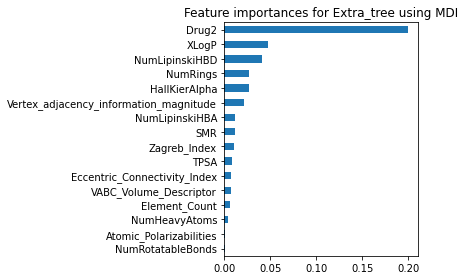

<Figure size 432x288 with 0 Axes>

In [103]:
# Feature importance for classifier model 
#https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

tree = DecisionTreeClassifier(criterion='entropy', random_state=3).fit(X_test, y_test) 
Extra_tree = ExtraTreesClassifier(n_estimators=1000, criterion='entropy', n_jobs=-1).fit(X_test, y_test) 

result1 = permutation_importance(tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
result2 = permutation_importance(Extra_tree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances_1 = pd.Series(result1.importances_mean, index=numeric_columns).sort_values(ascending=True)
forest_importances_2 = pd.Series(result2.importances_mean, index=numeric_columns).sort_values(ascending=True)
# print(result1.importances_mean)
# print(result1.importances_std)

# make barplots 
ax = forest_importances_2.plot.barh()
ax.set_title("Feature importances for Extra_tree using MDI")
ax.figure.tight_layout()

fig.tight_layout()
plt.show()
plt.savefig("220710 Feature importance for Binary Relevance(model) - Extra Tree Classifier Model.pdf", dpi=300)

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(diabetes.feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(diabetes.feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [188]:
# Construct a ranking with a feature utility metric, a function measuring associations between a feature and the target. 
for col in X.select_dtypes("object"):
    X[col], _ = X[col].factorize()
    
for col in X.columns: #change any float column to an int column.
    X[col] = X[col].astype(int)

discrete_features = X.dtypes == int

XLogP                                     False
SMR                                       False
TPSA                                      False
NumLipinskiHBA                             True
NumLipinskiHBD                             True
NumRotatableBonds                          True
NumHeavyAtoms                              True
NumRings                                   True
HallKierAlpha                             False
Atomic_Polarizabilities                   False
Element_Count                              True
Eccentric_Connectivity_Index               True
VABC_Volume_Descriptor                    False
Vertex_adjacency_information_magnitude    False
Zagreb_Index                               True
dtype: bool

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

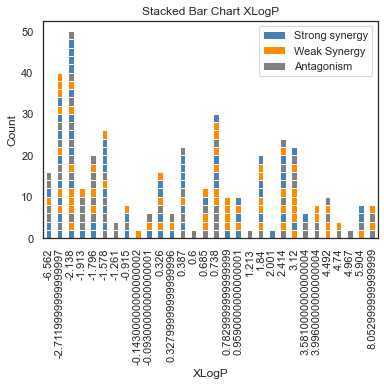

In [164]:
make_stacked_chart(df1_wide, 'XLogP', outcome='EC') #not concerned to very concerned

##  Partial least squares (Drug 2 == Beta-lactam)

In [731]:
from sklearn.multiclass import OneVsRestClassifier, OutputCodeClassifier
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict

In [14]:
%matplotlib inline

#define predictor and response variables
X = df_beta_lactam_drop[['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index', 'Drug2']]

y = df_beta_lactam_drop['exp_Synergyscore']

#define cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp = comp * var  # scale component by its variance explanation power
    plt.plot(
        [0, comp[0]],
        [0, comp[1]],
        label=f"Component {i}",
        linewidth=5,
        color=f"C{i + 2}",
    )
plt.gca().set(
    aspect="equal",
    title="2-dimensional dataset with principal components",
    xlabel="first feature",
    ylabel="second feature",
)
plt.legend()
plt.show()

TypeError: '(slice(None, None, None), 0)' is an invalid key

1 0.10629963726084507
2 0.10034218427541391
3 0.09543947758697069
4 0.0911966631447541
5 0.08776834852820654
6 0.08652649529091264
7 0.08328712126795741
8 0.07708732687168537
9 0.07649151861081305
10 0.07493392775778035
11 0.07397132765860087
12 0.07381529363572485
13 0.07339207441675451


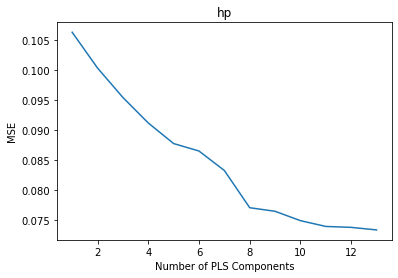

In [103]:
%matplotlib inline
#define predictor and response variables
X = df_beta_lactam_drop[['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index', 'bacteria_group', 'Drug2']]

y = df_beta_lactam_drop['exp_Synergyscore']

#define cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
# Mean square error (MSE) is the average of the square of the errors. The larger the number the larger the error between the observed y and predicted y values. 
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time

for i in np.arange(1, 14):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    print(i, score)
    mse.append(score)


#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')
#plt.savefig('220706_PLS-MSE plot for Drug2_Class = Beta-lactam.pdf', dpi=300)

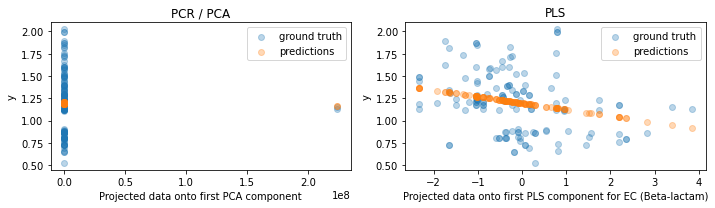

<Figure size 432x288 with 0 Axes>

In [15]:
pca = PCA(n_components=2).fit(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component for EC (Beta-lactam)", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()
plt.savefig('220706_PLS for Drug2_Class (Beta-lactam) EC.pdf', dpi=300)

In [12]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

pca_2 = make_pipeline(PCA(n_components=2), LinearRegression())
pca_2.fit(X_train, y_train)
print(f"PCR r-squared with 2 components {pca_2.score(X_test, y_test):.3f}")

PCR r-squared -0.505
PLS r-squared -0.494
PCR r-squared with 2 components -0.342


In [67]:
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42) 

#calculate RMSE
pls = PLSRegression(n_components=10)
pls.fit(scale(X_train), y_train)
print (np.sqrt(mean_squared_error(y_test, pls.predict(scale(X_test)))))

0.27595283833139156


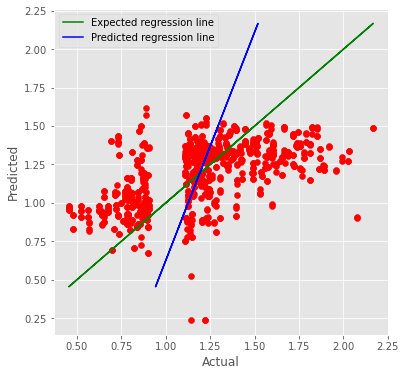

In [75]:
plt.figure(figsize=(6, 6))
with plt.style.context('ggplot'):
    plt.scatter(y, y_cv, color='red')
    plt.plot(y, y, '-g', label='Expected regression line')
    z = np.polyfit(y, y_cv, 1)
    plt.plot(np.polyval(z, y), y, color='blue', label='Predicted regression line')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend()
    plt.plot()

In [72]:
# Cross-validation
y_cv = cross_val_predict(pls, X, y, cv=10)
 
# Calculate scores
score = r2_score(y, y_cv)
mse = mean_squared_error(y, y_cv)

1 0.10809902985360927
2 0.10304777713564668
3 0.09899204080722404
4 0.09413471875764284
5 0.08965684812070242
6 0.08780683354152125
7 0.08404777033422692
8 0.08245424484004722
9 0.07962938924152418
10 0.07711739610815777
11 0.0768629542141995
12 0.07690683121250147
13 0.0801077715393403


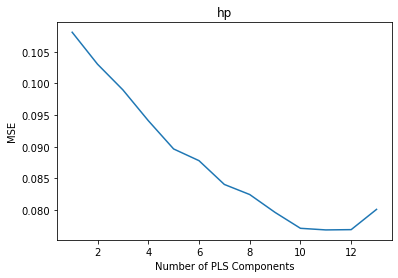

In [104]:
%matplotlib inline
#define predictor and response variables
X = ST_df3[['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index', 'Drug2']]

y = ST_df3['exp_Synergyscore']

#define cross-validation method
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
# Mean square error (MSE) is the average of the square of the errors. The larger the number the larger the error between the observed y and predicted y values. 
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time

for i in np.arange(1, 14):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    print(i, score)
    mse.append(score)


#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')
plt.savefig('220706_PLS-MSE plot for Drug2_Class (Beta-lactam) for ST ONLY.pdf', dpi=300)

1 0.10633257780001773
2 0.10038340610580469
3 0.09543425504865014
4 0.09110525665585881
5 0.08790047182756595
6 0.08664813636308043
7 0.08332613421352933
8 0.07777539530453843
9 0.07669868622675291


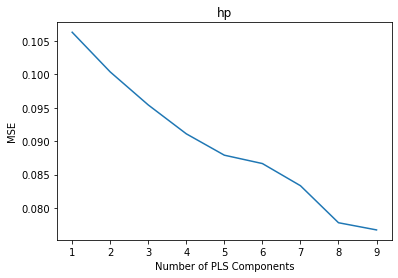

In [69]:
%matplotlib inline
X = df2[['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index', 'bacteria_group', 'Drug2']]

y = df2['exp_Synergyscore']

#define cross-validation method
cv = RepeatedKFold(n_splits=3, n_repeats=10, random_state=1)

mse = []
n = len(X)

# Calculate MSE with only the intercept
# Mean square error (MSE) is the average of the square of the errors. The larger the number the larger the error between the observed y and predicted y values. 
score = -1*model_selection.cross_val_score(PLSRegression(n_components=1),
           np.ones((n,1)), y, cv=cv, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time

for i in np.arange(1, 10):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, scale(X), y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    print(i, score)
    mse.append(score)


#plot test MSE vs. number of components
plt.plot(mse)
plt.xlabel('Number of PLS Components')
plt.ylabel('MSE')
plt.title('hp')
plt.savefig('220706_PLS-MSE plot for Drug2_Class = Beta-lactam.pdf', dpi=300)

In [ ]:


# Compute the validation error for each n_comp 
bug_plot = []
fat_plot = []
protein_plot = []

for n_comp in range(1, 14):
  my_plsr = PLSRegression(n_components=n_comp, scale=True)
  my_plsr.fit(X_train, y_train)
  preds = my_plsr.predict(X_val)

  water_rmse = sqrt(mean_squared_error(y_val[:,0] ,preds[:,0]))
  fat_rmse = sqrt(mean_squared_error(Y_val[:,1] ,preds[:,1]))
  protein_rmse = sqrt(mean_squared_error(Y_val[:,2] ,preds[:,2]))
  
  water_plot.append( water_rmse)
  fat_plot.append( fat_rmse)
  protein_plot.append(protein_rmse)

# Create the three plots using matplotlib
fig, axs = plt.subplots(1,3)

axs[0].plot(range(1, 14), water_plot)
axs[1].plot(range(1, 14), fat_plot)
axs[2].plot(range(1, 14), protein_plot)

fig.show()

In [ ]:
# PLS-2 (multiple Y variables)

EC_plot = []
PA_plot = []
ST_plot = []

%matplotlib inline
#define predictor and response variables
X = df2[['XLogP', 'SMR', 'TPSA', 'NumLipinskiHBA', 'NumLipinskiHBD', 'NumRotatableBonds', 'NumHeavyAtoms', 'NumRings', 'HallKierAlpha',
'Atomic_Polarizabilities', 'Element_Count', 'Eccentric_Connectivity_Index', 'VABC_Volume_Descriptor', 'Vertex_adjacency_information_magnitude', 
'Zagreb_Index']]

y = df2['exp_Syneryscore']

for n_comp in range(1, 10):
  my_plsr = PLSRegression(n_components=n_comp, scale=True)
  my_plsr.fit(X_train, Y_train)
  preds = my_plsr.predict(X_val)

  EC_rmse = sqrt(mean_squared_error(Y_val[:,0] ,preds[:,0]))
  PA_rmse = sqrt(mean_squared_error(Y_val[:,1] ,preds[:,1]))
  ST_rmse = sqrt(mean_squared_error(Y_val[:,2] ,preds[:,2]))
    
 # EC_plot.append(EC_rmse)
  #PA_plot.append(PA_rmse)
  #ST_plot.append(ST_rmse)